# Final Project

## Human Baseline Script 

To establish a human baseline, we designed a quiz that randomly samples text snippets from a labeled pool of Shakespearean and non-Shakespearean works. After preprocessing to remove blank lines and speaker-only entries, we randomly select an equal number of samples from each group. Snippets are constructed by grouping a fixed number of consecutive lines into a single question. Users are prompted to classify each snippet as "Shakespeare" or "Not Shakespeare," and their responses are recorded alongside the true labels. This method produces a human-generated labeled dataset that can later be compared directly against machine learning model predictions.

INSTRUCTIONS:

Just run it and answer. Your answers are saved and added to the human_quiz_results.csv at the end of the quiz. So if anything goes wrong, you can stop the quiz and restart without your answers getting saved. I set it so the quiz will give you 25 questions with a snippet of 5 lines for each question. If you want to change that, see the 'Quiz Settings' section and change the variables LINES_PER_QUESTION and DESIRED_NUM_QUESTIONS to your liking.

In [1]:
import pandas as pd
import random
import os

# -----------------------------
# 1. Load and Clean Data
# -----------------------------

# Load Shakespeare and Non-Shakespeare datasets
shakespeare_df = pd.read_csv('shakespeare.csv')
non_shakespeare_df = pd.read_csv('nonShakespeare.csv')

# Label them internally
shakespeare_df['label'] = 1
non_shakespeare_df['label'] = 0

# Clean text function
def clean_text(df):
    df = df.dropna(subset=['text'])
    df = df[df['text'].str.strip() != '']
    df = df.reset_index(drop=True)
    # Drop lines that are just character names
    df = df[~((df['text'].str.endswith(':')) & (df['text'].str.len() <= 20))]
    df = df.reset_index(drop=True)
    return df

shakespeare_df = clean_text(shakespeare_df)
non_shakespeare_df = clean_text(non_shakespeare_df)

# -----------------------------
# 2. Quiz Settings
# -----------------------------

LINES_PER_QUESTION = 5  # lines per snippet

# Calculate max number of full questions possible
max_questions_shakespeare = len(shakespeare_df) // LINES_PER_QUESTION
max_questions_nonshakespeare = len(non_shakespeare_df) // LINES_PER_QUESTION

# Pick the maximum possible number of questions
max_possible_questions = (max_questions_shakespeare + max_questions_nonshakespeare)

# Set how many total questions you want (or max possible)
DESIRED_NUM_QUESTIONS = 25

NUM_QUESTIONS = min(DESIRED_NUM_QUESTIONS, max_possible_questions)

# Split questions evenly
half_questions = NUM_QUESTIONS // 2

# Randomly sample
sample_size_shakespeare = half_questions * LINES_PER_QUESTION
sample_size_nonshakespeare = (NUM_QUESTIONS - half_questions) * LINES_PER_QUESTION

shakespeare_sample = shakespeare_df.sample(n=sample_size_shakespeare, random_state=random.randint(0, 9999)).reset_index(drop=True)
non_shakespeare_sample = non_shakespeare_df.sample(n=sample_size_nonshakespeare, random_state=random.randint(0, 9999)).reset_index(drop=True)

# -----------------------------
# 3. Build Questions
# -----------------------------

def group_lines(df, lines_per_group):
    grouped = []
    for i in range(0, len(df) - lines_per_group + 1, lines_per_group):
        snippet = "\n".join(df.iloc[i:i+lines_per_group]['text'])
        label = df.iloc[i]['label']
        grouped.append({'text': snippet, 'true_label': label})
    return grouped

shakespeare_questions = group_lines(shakespeare_sample, LINES_PER_QUESTION)
non_shakespeare_questions = group_lines(non_shakespeare_sample, LINES_PER_QUESTION)

# Combine and shuffle
all_questions = shakespeare_questions + non_shakespeare_questions
random.shuffle(all_questions)

# -----------------------------
# 4. Start the Quiz
# -----------------------------

print("\nHuman Baseline Quiz: Is This Shakespeare?\n")
print(f"Instructions: After reading the snippet ({LINES_PER_QUESTION} lines), enter 'y' for YES (Shakespeare) or 'n' for NO (Not Shakespeare).\n")
print(f"Total questions this session: {NUM_QUESTIONS}\n")

user_responses = []

for idx, q in enumerate(all_questions):
    print("-" * 50)
    print(f"Question {idx + 1} / {NUM_QUESTIONS}")
    print("-" * 50)
    print("\nSnippet:\n")
    print(q['text'])
    print("\n")

    while True:
        user_input = input("Is this Shakespeare? (y/n): ").strip().lower()
        if user_input in ['y', 'n']:
            break
        else:
            print("Invalid input. Please enter 'y' for YES or 'n' for NO.")

    user_responses.append({
        'text': q['text'],
        'true_label': q['true_label'],
        'human_answer': 1 if user_input == 'y' else 0
    })

# -----------------------------
# 5. Save Results (APPEND)
# -----------------------------

results_df = pd.DataFrame(user_responses)
filename = 'human_quiz_results.csv'

if os.path.exists(filename):
    old_df = pd.read_csv(filename)
    full_df = pd.concat([old_df, results_df], ignore_index=True)
else:
    full_df = results_df

full_df.to_csv(filename, index=False)

print(f"\nQuiz completed! Your answers have been saved to '{filename}'.\n")



Human Baseline Quiz: Is This Shakespeare?

Instructions: After reading the snippet (5 lines), enter 'y' for YES (Shakespeare) or 'n' for NO (Not Shakespeare).

Total questions this session: 25

--------------------------------------------------
Question 1 / 25
--------------------------------------------------

Snippet:

Yes
say he lies?
A single thing
Have just our theme of woe; but for the miracle
Which thou takest from me. When thou camest first




KeyboardInterrupt: Interrupted by user

## RNN (LSTM)

In [16]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter

# Load datasets
df1 = pd.read_csv("shakespeare.csv") 
df1["label"] = "shakespeare" 

df2 = pd.read_csv("nonShakespeare.csv")  # temporary?
df2["label"] = "non-shakespeare"  


# Combine datasets
df = pd.concat([df1, df2], ignore_index=True)

# Ensure no NaN and make sure text is string type
df['text'] = df['text'].fillna("").astype(str)

# Tokenize and Build Vocabulary
def tokenize(text):
    return text.lower().split()

all_tokens = []
sentence_lengths = []

for text in df['text']:
    tokens = tokenize(text)
    all_tokens.extend(tokens)
    sentence_lengths.append(len(tokens))

vocab = {word: idx+1 for idx, word in enumerate(set(all_tokens))}

# Auto-select max sentence length that covers 90% of sentences (actual max may be an outlier)
percentile = 90
max_len = int(np.percentile(sentence_lengths, percentile))
print(f"Auto-selected max_len (covers {percentile}% of sentences):", max_len)

# Encode sentences
def encode(text):
    tokens = [vocab.get(word, 0) for word in tokenize(text)]
    tokens += [0] * (max_len - len(tokens))
    return tokens[:max_len]

X = [encode(text) for text in df['text']]
y = LabelEncoder().fit_transform(df['label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Dataset and DataLoader
class ShakespeareDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.LongTensor(X)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = ShakespeareDataset(X_train, y_train)
test_ds = ShakespeareDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)

# LSTM Model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size + 1, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden[-1])
        return out

model = LSTMClassifier(vocab_size=len(vocab), embed_dim=32, hidden_dim=64, output_dim=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
for epoch in range(5):
    for inputs, targets in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

print("Training Complete.")

# Evaluation
model.eval()
correct = 0
total = len(X_test)

with torch.no_grad():
    for i in range(total):
        x = torch.LongTensor([X_test[i]])
        y_true = y_test[i]
        y_pred = model(x).argmax(dim=1).item()
        if y_pred == y_true:
            correct += 1

print("Test Accuracy:", correct / total)


Auto-selected max_len (covers 90% of sentences): 10
Training Complete.
Test Accuracy: 0.853904282115869


## Bigram Language Model

## FFNN Model

/root/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_82/2421945829.py:48: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  predicted_vector = self.softmax(output_logits)  # softmax and log probability
dim=2, epoch=2 => accuracy=0.3939
dim=2, epoch=4 => accuracy=0.3939
dim=2, epoch=8 => accuracy=0.6061
dim=2, epoch=16 => accuracy=0.4242
dim=2, epoch=32 => accuracy=0.9091
dim=2, epoch=64 => accuracy=0.9394
dim=4, epoch=2 => accuracy=0.6061
dim=4, epoch=4 => accuracy=0.6061
dim=4, epoch=8 => accuracy=0.3939
dim=4, epoch=16 => accuracy=0.9394
dim=4, epoch=32 => accuracy=0.8788
dim=4, epoch=64 => accuracy=0.3939
dim=8, epoch=2 => accuracy=0.3939
dim=8, epoch=4 => accuracy=0.5758
dim=8, epoch=8 => accuracy=0.939

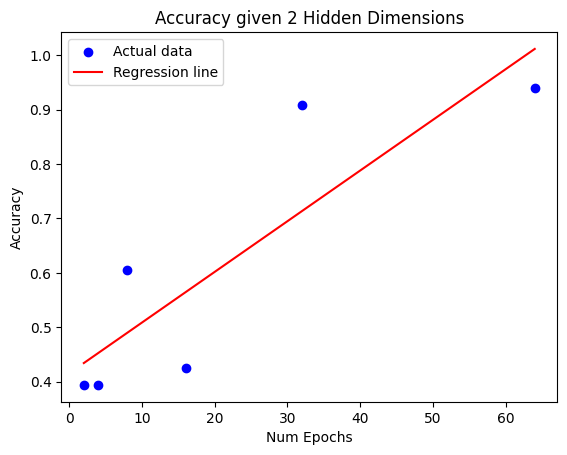

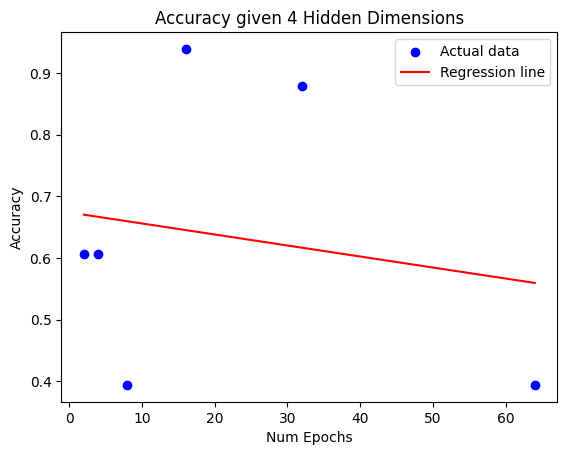

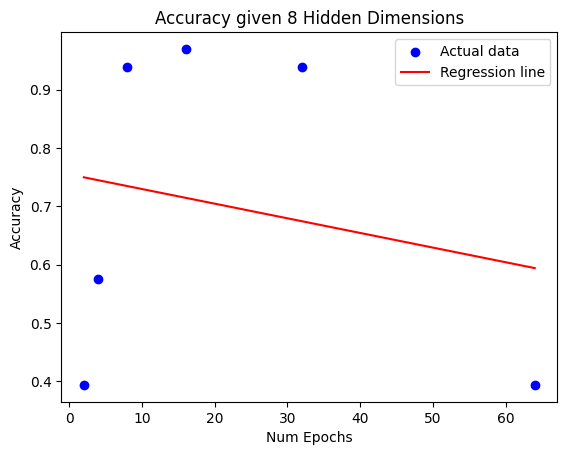

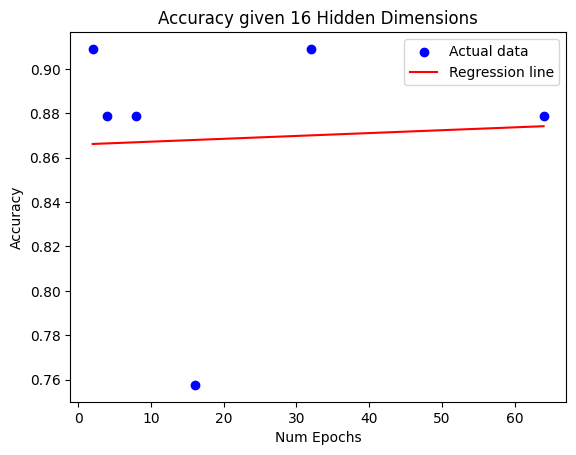

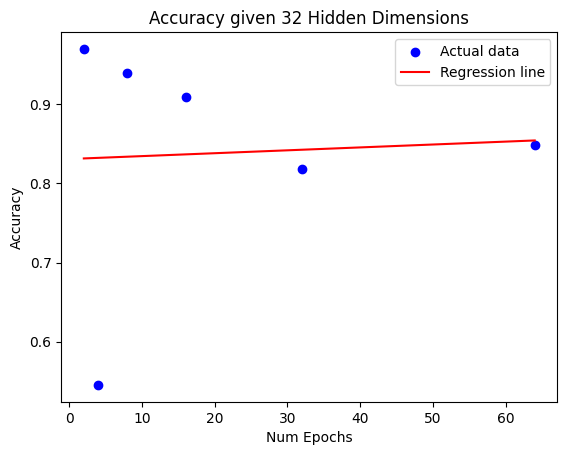

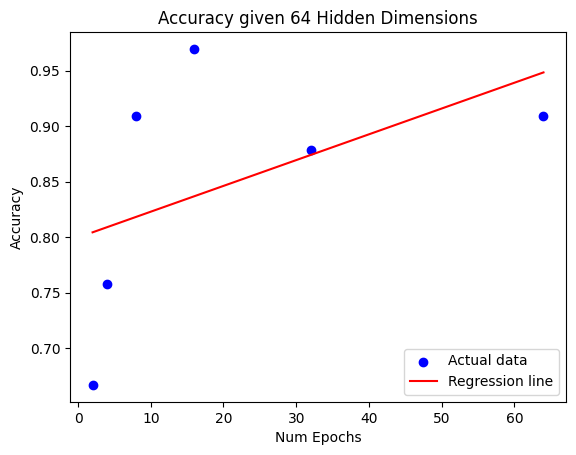

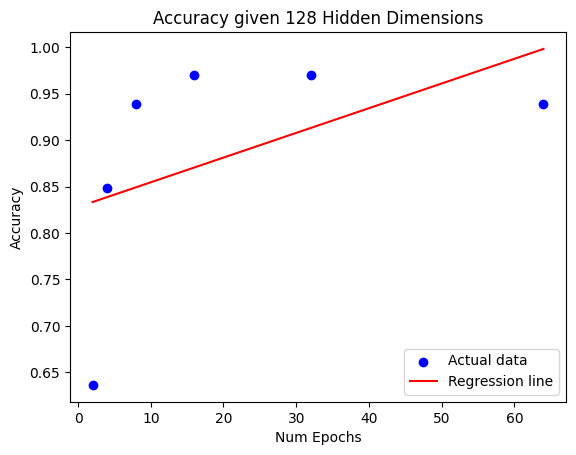

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import init
import torch.optim as optim
import math
import random
import os
import time
from tqdm import tqdm
import json
from argparse import ArgumentParser
import random
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

unk = '<UNK>'
class FFNN(nn.Module):
    def __init__(self, input_dim, h):
        super(FFNN, self).__init__()
        self.flops = 0 #tracking its running time...ish
        self.h = h
        self.W1 = nn.Linear(input_dim, h)
        self.activation = nn.ReLU() # The rectified linear unit; one valid choice of activation function
        self.output_dim = 5
        self.W2 = nn.Linear(h, self.output_dim)

        self.softmax = nn.LogSoftmax() # The softmax function that converts vectors into probability distributions; computes log probabilities for computational benefits
        self.loss = nn.NLLLoss() # The cross-entropy/negative log likelihood loss taught in class

    def compute_Loss(self, predicted_vector, gold_label):
        return self.loss(predicted_vector, gold_label)

    def forward(self, input_vector): # notes: gets called automatically when pytorch calls in the model
        self.flops += 2 * input_vector.shape[0] * self.W1.in_features * self.W1.out_features
        hidden_representation = self.W1(input_vector)  # shape of the layer [batch_size, h]
        # multiplied by the weight of the vector
        # puts high dimensional vector into lower dimensional space
        activated = self.activation(hidden_representation)  # rectified linear unit applies to elements
        # basically, introduces the non-linearity

        self.flops += 2 * activated.shape[0] * self.W2.in_features * self.W2.out_features
        output_logits = self.W2(activated)  # new weight is introduced
        #gets raw scores for the 5 classes/score (1-5)
        # combines hidden into classes

        predicted_vector = self.softmax(output_logits)  # softmax and log probability
        
        return predicted_vector

# # # # # # # # # ORDER OF IMPORTING DATA # # # # # # # # # #

def load_data(train_file, val_file, test_file):
    import pandas as pd
    train_df = pd.read_csv(train_file)
    val_df = pd.read_csv(val_file)
    test_df = pd.read_csv(test_file)

    # converting the dataframe (due to csv) to a tuple (due to json)
    train_data = list(zip(train_df["text"], train_df["label"]))
    valid_data = list(zip(val_df["text"], val_df["label"]))
    test_data = list(zip(test_df["text"], test_df["label"]))

    return train_data, valid_data, test_data

# Returns: 
# vocab = A set of strings corresponding to the vocabulary
def make_vocab(data):
    vocab = set()
    for document, _ in data:
        for word in document:
            vocab.add(word)
    return vocab 


# Returns:
# vocab = A set of strings corresponding to the vocabulary including <UNK>
# word2index = A dictionary mapping word/token to its index (a number in 0, ..., V - 1)
# index2word = A dictionary inverting the mapping of word2index
def make_indices(vocab):
    vocab_list = sorted(vocab)
    vocab_list.append(unk)
    word2index = {}
    index2word = {}
    for index, word in enumerate(vocab_list):
        word2index[word] = index
        index2word[index] = word
    vocab.add(unk)
    return vocab, word2index, index2word 


# Returns:
# vectorized_data = A list of pairs (vector representation of input, y)
def convert_to_vector_representation(data, word2index):
    vectorized_data = []
    for document, y in data:
        vector = torch.zeros(len(word2index))
        for word in document:
            index = word2index.get(word, word2index[unk])
            vector[index] += 1
        vectorized_data.append((vector, y))
    return vectorized_data


# load data
# print("========== Loading data ==========")
train_data, valid_data, test_data = load_data('./dataset/train_data.csv', './dataset/val_data.csv', './dataset/test_data.csv')
vocab = make_vocab(train_data)
vocab, word2index, index2word = make_indices(vocab)

# print("========== Vectorizing data ==========")
train_data = convert_to_vector_representation(train_data, word2index)
valid_data = convert_to_vector_representation(valid_data, word2index)
test_data = convert_to_vector_representation(test_data, word2index)

# HYPER PARAMETERS #########

def run_model(dims, eps):
    hidden_dim = dims
    epochs = eps


    model = FFNN(input_dim = len(vocab), h = hidden_dim)
    optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.9)
    # print("========== Training for {} epochs ==========".format(epochs))
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        loss = None
        correct = 0
        total = 0
        start_time = time.time()
        # print("Training started for epoch {}".format(epoch + 1))
        random.shuffle(train_data) # Good practice to shuffle order of training data
        minibatch_size = 16 
        N = len(train_data) 
        for minibatch_index in tqdm(range(N // minibatch_size), disable=True):
            optimizer.zero_grad()
            loss = None
            for example_index in range(minibatch_size):
                input_vector, gold_label = train_data[minibatch_index * minibatch_size + example_index]
                predicted_vector = model(input_vector)
                predicted_label = torch.argmax(predicted_vector)
                correct += int(predicted_label == gold_label)
                total += 1
                example_loss = model.compute_Loss(predicted_vector.view(1,-1), torch.tensor([gold_label]))
                if loss is None:
                    loss = example_loss
                else:
                    loss += example_loss
            loss = loss / minibatch_size
            loss.backward()
            optimizer.step()
        # print("Training completed for epoch {}".format(epoch + 1))
        # print("Training accuracy for epoch {}: {}".format(epoch + 1, correct / total))
        # print("Training time for this epoch: {}".format(time.time() - start_time))

        loss = None
        correct = 0
        total = 0
        start_time = time.time()
        # print("Validation started for epoch {}".format(epoch + 1))
        minibatch_size = 16 
        N = len(valid_data) 
        for minibatch_index in tqdm(range(N // minibatch_size), disable=True):
            optimizer.zero_grad()
            loss = None
            for example_index in range(minibatch_size):
                input_vector, gold_label = valid_data[minibatch_index * minibatch_size + example_index]
                predicted_vector = model(input_vector)
                predicted_label = torch.argmax(predicted_vector)
                correct += int(predicted_label == gold_label)
                total += 1
                example_loss = model.compute_Loss(predicted_vector.view(1,-1), torch.tensor([gold_label]))
                if loss is None:
                    loss = example_loss
                else:
                    loss += example_loss
            loss = loss / minibatch_size
        # print("Validation completed for epoch {}".format(epoch + 1))
        # print("Validation accuracy for epoch {}: {}".format(epoch + 1, correct / total))
        # print("Validation time for this epoch: {}".format(time.time() - start_time))


    # Running portion
    # print("\n========== Testing on New Data ==========")

    model.eval()  # evaluating
    correct = 0
    total = 0
    predictions = []

    with torch.no_grad():  # disabling the gradient calculation
        for input_vector, gold_label in test_data:
            predicted_vector = model(input_vector)
            predicted_label = torch.argmax(predicted_vector).item()
            predictions.append(predicted_label)
            correct += int(predicted_label == gold_label)
            total += 1

    torch.save(model.state_dict(), "ffnn_model.pt")
    # printing the results
    test_accuracy = correct / total
    return test_accuracy
    

# accuracy = run_model(8, 64)
# print(f"dim={8}, epoch={64} => accuracy={accuracy:.4f}")

dims =   [2, 4, 8, 16, 32, 64, 128]
epochs = [2, 4, 8, 16, 32, 64]
results = []

for dim in dims:
    row = []
    for epoch in epochs:
        accuracy = run_model(dim, epoch)
        row.append(accuracy)
        print(f"dim={dim}, epoch={epoch} => accuracy={accuracy:.4f}")
    results.append(row)

for row in range(len(results)):
    X = np.array(epochs)
    y = np.array(results[row])
    
    # lin reg fit
    coeffs = np.polyfit(X, y, 1)
    y_pred = np.poly1d(coeffs)(X)

    plt.scatter(X, y, color='blue', label='Actual data')
    plt.plot(X, y_pred, color='red', label='Regression line')
    plt.xlabel('Num Epochs')
    plt.ylabel('Accuracy')
    plt.title(f"Accuracy given {dims[row]} Hidden Dimensions")
    plt.legend()
    plt.show()
    print()


In [ ]:
accuracy = run_model(8, 64)

## Evaluation

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4cd1bb92-5c33-4c71-9500-71d9821d29e2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>